<a href="https://colab.research.google.com/github/bhatiavr/cs109b-final-project-111/blob/master/PB_Vivek_cs109b_wastewater_covid_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/"My Drive"/ColabHome/2021_109B/Final_Project/src/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/ColabHome/2021_109B/Final_Project/src


In [3]:
!pip install arviz pygam

In [4]:
# Load useful libraries
import numpy as np
import pandas as pd
import os
import tqdm
import pathlib
import time
import pickle
import seaborn as sns
import matplotlib.dates as mdates
from pygam import LinearGAM, s

import arviz as az
import pymc3 as pm
import patsy as pt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures


# Plotting libraries
from matplotlib import pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Common Utilities

In [5]:
from tensorflow.keras import backend
import tensorflow as tf
import sklearn
#from sklearn.metrics import mean_absolute_percentage_error

In [6]:
def deco_run_store_plot_validation(func):    
    def wrap_deco_run_store_plot_validation(*args):
        model_name = args[0]
        y_true = args[1]
        y_pred = args[2]
        # temp = np.asarray(train_y).astype(np.float32)
        # predictions = np.asarray(train_y).astype(np.float32)
        result_list = []
        results=[]
        val = func(model_name,y_true, y_pred)
        results.append(model_name)
        results.append(time.strftime('%Y:%m:%d'))
        results.append(func.__name__)
        results.append(tf.keras.backend.get_value(val))
        print(val)
        result_list.append(results)
        with open('validation_results.csv','ab')as fp:
            np.savetxt(fp,  result_list,delimiter=',',fmt='% s',newline='\n')

    return wrap_deco_run_store_plot_validation 

In [7]:

# Calculate RMSE
@deco_run_store_plot_validation
def rmse_calc(model_name,y_true,y_pred):
    return sklearn.metrics.mean_squared_error(y_true,y_pred)



In [8]:
# MAE 
@deco_run_store_plot_validation
def mae_calc(model_name,y_true,y_pred):
    return sklearn.metrics.mean_absolute_error(y_true,y_pred)


In [9]:
# MAPE 
@deco_run_store_plot_validation
def mape_calc(model_name,y_true,y_pred):
    return sklearn.metrics.mean_absolute_percentage_error(y_true,y_pred)

In [10]:
@deco_run_store_plot_validation
def corr_calc(model_name,y_true,y_pred):
    return sklearn.metrics.matthews_corrcoef(y_true,y_pred)

In [11]:
def execute_all_validations(model_name,y_true,y_pred):
    #for extFunc in (mape_calc, corr_calc, mae_calc, rmse_calc ):
    for extFunc in ( mae_calc, rmse_calc ):
        #extFunc(df_test['Cases_Avg'].values,test_preds['mean'].values)
        extFunc(model_name,y_true ,y_pred )


# EDA and data analysis 

In [12]:
DATA_DIR="../datasets/"

MWRA_DATA_DIR=os.path.join(DATA_DIR, "mwra")
MWRA_DATA_FILE=os.path.join(MWRA_DATA_DIR, "data-20210430.csv")

MASS_COVID_DATA_DIR=os.path.join(DATA_DIR, "mass-covid")
MASS_COVID_DATA_FILE=os.path.join(MASS_COVID_DATA_DIR, "covid-19-raw-data-4-30-2021.xlsx")

In [13]:
# Load MWRA dataset
df_mwra = pd.read_csv(MWRA_DATA_FILE, parse_dates=['Date'])
display(df_mwra.tail(5))
df_mwra.interpolate(method="akima", limit_direction='both', inplace=True)

# Fill remaining values with 0
df_mwra.fillna(0, inplace=True)

,Date,Southern (copies/mL),Northern (copies/mL),Southern 7 day avg,Northern 7 day avg,Southern Low Confidence Interval,Southern High Confidence Interval,Northern Low Confidence Interval,Northern High Confidence Interval,Southern Variant Results,Northern Variant Results
420,2021-04-25,238.0,176.0,229.0,133.0,75.0,110.0,56.0,81.0,63%,60%
421,2021-04-26,209.0,154.0,235.0,130.0,66.0,96.0,49.0,71.0,64%,49%
422,2021-04-27,139.0,107.0,223.0,126.0,44.0,64.0,34.0,49.0,59%,58%
423,2021-04-28,157.0,102.0,215.0,118.0,50.0,72.0,32.0,47.0,NaN,NaN
424,2021-04-29,231.0,133.0,202.0,122.0,73.0,107.0,42.0,61.0,NaN,NaN


In [14]:
df_mwra.isna().sum()

Date                                 0
Southern (copies/mL)                 0
Northern (copies/mL)                 0
Southern 7 day avg                   0
Northern 7 day avg                   0
Southern Low Confidence  Interval    0
Southern High Confidence Interval    0
Northern Low Confidence Interval     0
Northern High Confidence Interval    0
Southern Variant Results             0
Northern Variant Results             0
dtype: int64

In [15]:
# Describe the dataset
df_mwra.describe()

,Southern (copies/mL),Northern (copies/mL),Southern 7 day avg,Northern 7 day avg,Southern Low Confidence Interval,Southern High Confidence Interval,Northern Low Confidence Interval,Northern High Confidence Interval
count,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,294.843623,266.886846,272.633984,255.798335,86.204706,126.032941,74.644706,109.068235
std,383.722752,313.458548,314.903703,277.811360,124.252417,181.671572,99.294865,145.142391
min,-3.236515,-133.414654,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.000000,44.000000,43.000000,48.000000,5.000000,8.000000,7.000000,10.000000
50%,164.000000,167.000000,136.000000,155.000000,32.000000,47.000000,34.000000,49.000000
75%,390.000000,360.000000,374.000000,332.000000,118.000000,173.000000,100.000000,146.000000
max,3772.000000,1451.000000,1476.000000,1130.000000,1192.000000,1743.000000,458.000000,670.000000


Text(0.5, 1.05, 'Relationship plot between Southern and Northern Viral Titers')

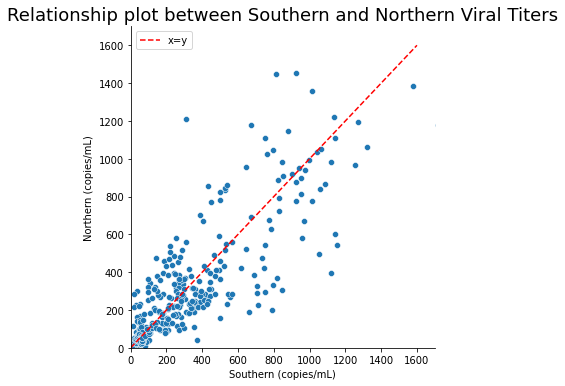

In [16]:
# Show the relation between norther and souther samples
sns.relplot(data=df_mwra, x="Southern (copies/mL)", y="Northern (copies/mL)")
plt.plot([0,1600], [0,1600], '--r', label="x=y")
plt.xlim([0, 1700])
plt.ylim([0, 1700])
plt.legend()
plt.title('Relationship plot between Southern and Northern Viral Titers', fontsize=18, y=1.05)

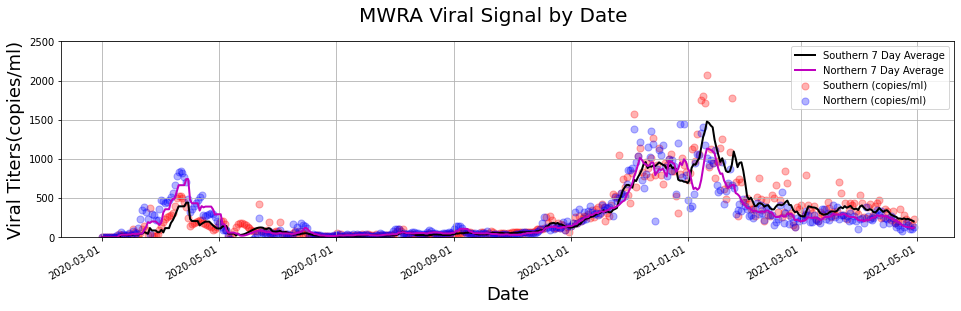

In [17]:
# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.scatter(df_mwra['Date'], df_mwra['Southern (copies/mL)'], color='r', s = 50, alpha=0.3, label="Southern (copies/ml)")
ax.scatter(df_mwra['Date'], df_mwra['Northern (copies/mL)'], color='b', s = 50, alpha=0.3, label="Northern (copies/ml)")
ax.plot(df_mwra['Date'], df_mwra['Southern 7 day avg'], 'k', linewidth = 2,  label="Southern 7 Day Average")
ax.plot(df_mwra['Date'], df_mwra['Northern 7 day avg'], 'm', linewidth = 2, label="Northern 7 Day Average")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 2500])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Viral Titers(copies/ml)', fontsize=18)

fig.autofmt_xdate()
fig.suptitle('MWRA Viral Signal by Date', fontsize=20, y=1.00)
fig.show()

In [18]:
# Load Mass-COVID dataset
df_covid= pd.read_excel(MASS_COVID_DATA_FILE,sheet_name='County_Daily', parse_dates=['Date'])
#display(df_covid.tail(5))

df_covid.rename(columns={"New Confirmed Cases": "Cases", "New Probable and Confirmed Deaths": "Deaths"}, inplace=True)
df_covid.drop(['Total Confirmed Cases', 'Total Probable and Confirmed Deaths'], axis=1, inplace=True)

# Add the old-covid 19 values to the dataset
#MASS_COVID_OLD_DATA_FILE=os.path.join(MASS_COVID_DATA_DIR, "covid-19-raw-data-8-5-2020/County.csv")

#df_covid_2 = pd.read_csv(MASS_COVID_OLD_DATA_FILE, parse_dates=['Date'])
#df_covid_2.rename(columns={"Count": "Cases"}, inplace=True)

# Append the two dataframes
#df_covid = df_covid.append(df_covid_2, ignore_index=True)
# Sort by data and re-index
#df_covid = df_covid.sort_values(by="Date")
#df_covid.reset_index(drop=True, inplace=True)

display(df_covid.tail(10))

,Date,County,Cases,Deaths
3990,2021-04-30,Hampden,128.0,5.0
3991,2021-04-30,Hampshire,13.0,0.0
3992,2021-04-30,Middlesex,237.0,2.0
3993,2021-04-30,Nantucket,4.0,NaN
3994,2021-04-30,Norfolk,99.0,0.0
3995,2021-04-30,Plymouth,97.0,1.0
3996,2021-04-30,Suffolk,135.0,3.0
3997,2021-04-30,Worcester,124.0,0.0
3998,2021-04-30,Unknown,-8.0,0.0
3999,2021-04-30,Dukes and Nantucket,NaN,0.0


In [19]:
df_covid.isna().sum()

Date        0
County      0
Cases     252
Deaths    500
dtype: int64

In [20]:
#Impute missing values
df_covid.interpolate(method="akima", limit_direction='both', inplace=True)
# Fill remaining values with 0
df_covid.fillna(0, inplace=True)
df_covid.isna().sum()

Date      0
County    0
Cases     0
Deaths    0
dtype: int64

In [21]:
# Describe the dataset
df_covid.describe()

,Cases,Deaths
count,4000.000000,4000.000000
mean,134.180520,2.818219
std,205.385985,3.510118
min,-69.000000,-1.000000
25%,8.000000,0.000000
50%,43.330750,2.000000
75%,176.000000,4.000000
max,1607.000000,24.000000


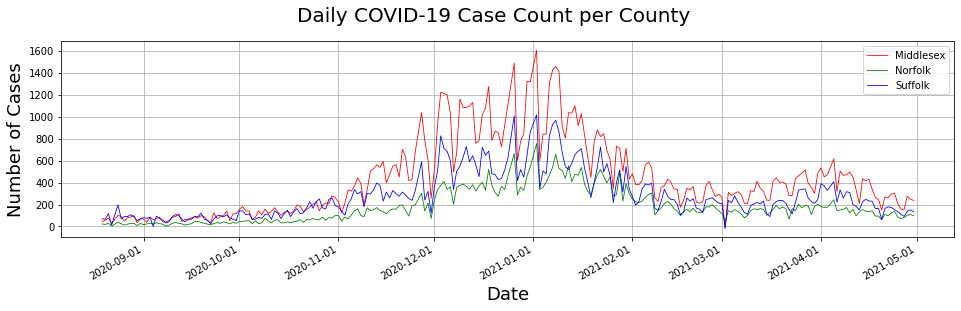

In [22]:
# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

df_ms = df_covid[df_covid['County'].str.contains("Middlesex", case = False)]
df_nr = df_covid[df_covid['County'].str.contains("Norfolk", case = False)]
df_sf = df_covid[df_covid['County'].str.contains("Suffolk", case = False)]

# Plot southern samples
ax.plot(df_ms['Date'], df_ms['Cases'], 'r', linewidth = 0.8, label="Middlesex")
ax.plot(df_ms['Date'], df_nr['Cases'], 'g', linewidth = 0.8, label="Norfolk")
ax.plot(df_ms['Date'], df_sf['Cases'], 'b', linewidth = 0.8, label="Suffolk")


ax.grid(True)
ax.legend()
#ax.set_ylim([0, 2500])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Number of Cases', fontsize=18)


fig.autofmt_xdate()
fig.suptitle('Daily COVID-19 Case Count per County', fontsize=20, y=1.00)
fig.show()

In [23]:
df_combined = pd.DataFrame(data=None, columns=['Date', 'Cases', 'Deaths'])

allDates = df_covid['Date'].unique()

for i, i_date in enumerate(allDates):
    totalCases = 0
    totalDeaths = 0

    
    # Add middlesex cases
    row = df_ms[df_ms['Date'] == i_date]
    if not row.empty:
        totalCases += row['Cases'].to_list()[0]
        totalDeaths += row['Deaths'].to_list()[0]
        
    # Add norfolk cases
    row = df_nr[df_nr['Date'] == i_date]
    if not row.empty:
        totalCases += row['Cases'].to_list()[0]
        totalDeaths += row['Deaths'].to_list()[0]

        
    # Add norfolk cases
    row = df_sf[df_sf['Date'] == i_date]
    if not row.empty:
        totalCases += row['Cases'].to_list()[0]
        totalDeaths += row['Deaths'].to_list()[0]

        
    df_combined.at[i, 'Date'] = i_date
    df_combined.at[i, 'Cases'] = totalCases
    df_combined.at[i, 'Deaths'] = totalDeaths

df_combined['Date'] = pd.to_datetime(df_combined['Date'])
display(df_combined)

,Date,Cases,Deaths
0,2020-08-19,135,16
1,2020-08-20,142,3
2,2020-08-21,221,3
3,2020-08-22,41,6
4,2020-08-24,340,13
...,...,...,...
245,2021-04-26,339,5
246,2021-04-27,329,1
247,2021-04-28,514,4
248,2021-04-29,507,5


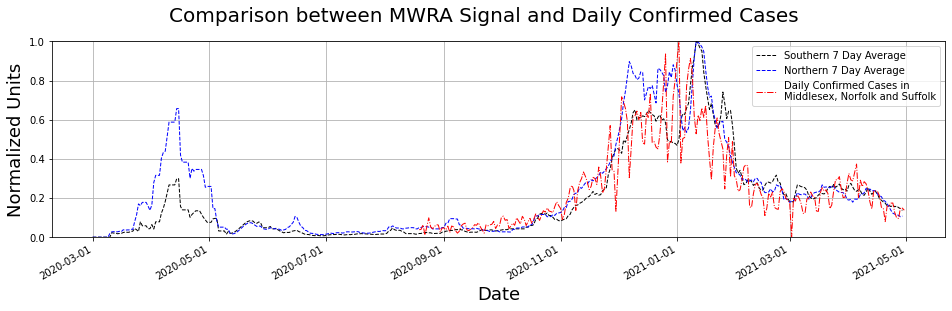

In [24]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_mwra['Date'], normalize(df_mwra['Southern 7 day avg'].to_numpy()), '--k', linewidth = 1,  label="Southern 7 Day Average")
ax.plot(df_mwra['Date'], normalize(df_mwra['Northern 7 day avg'].to_numpy()), '--b', linewidth = 1, label="Northern 7 Day Average")
ax.plot(df_combined['Date'], normalize(df_combined['Cases'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")
#ax.plot(df_combined['Date'], normalize(df_combined['Deaths'].to_numpy()), '-.b', linewidth = 1, label="Daily Confirmed Deaths in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

In [25]:
# Create algined matrix between southern, northen and covid cases
df_aligned = pd.DataFrame(data=None, columns=['Date', 'Southern_Raw', 'Northern_Raw', 
                                              'Southern_Avg', 'Northern_Avg', 
                                                'Southern_Variant', 'Northern_Variant',
                                              'Cases', 'Deaths'])

covidDates = df_covid['Date'].unique()
mwraDates = df_mwra['Date'].unique()
commonDates = np.intersect1d(covidDates, mwraDates)

for i, i_date in enumerate(commonDates):
    total = 0
    
    row = df_mwra[df_mwra['Date'] == i_date]
    if not row.empty:
        df_aligned.at[i, 'Southern_Raw'] = row['Southern (copies/mL)'].to_list()[0]
        df_aligned.at[i, 'Northern_Raw'] = row['Northern (copies/mL)'].to_list()[0]
        df_aligned.at[i, 'Southern_Avg'] = row['Southern 7 day avg'].to_list()[0]
        df_aligned.at[i, 'Northern_Avg'] = row['Northern 7 day avg'].to_list()[0]
        df_aligned.at[i, 'Southern_Variant'] = row['Southern Variant Results'].to_list()[0]
        df_aligned.at[i, 'Northern_Variant'] = row['Northern Variant Results'].to_list()[0]
        
        
    row = df_combined[df_combined['Date'] == i_date]
    if not row.empty:
        df_aligned.at[i, 'Cases'] = row['Cases'].to_list()[0]
        df_aligned.at[i, 'Deaths'] = row['Deaths'].to_list()[0]
        
    df_aligned.at[i, 'Date'] = i_date

# Reformat dates
df_aligned['Date'] = pd.to_datetime(df_aligned['Date'])

In [26]:
# Scale confirmed cases by population per 100,000
MIDDLESEX_POPULATION = 1611699
NORFOLK_POPULATION = 11786
SUFFOLK_POPULATION = 803907
MASS_POPULATION = (MIDDLESEX_POPULATION + NORFOLK_POPULATION + SUFFOLK_POPULATION) / 100000

df_aligned['Cases_per_100K'] = df_aligned['Cases'] / MASS_POPULATION
df_aligned['Deaths_per_100K'] = df_aligned['Deaths'] / MASS_POPULATION

In [27]:
display(df_aligned.head())

,Date,Southern_Raw,Northern_Raw,Southern_Avg,Northern_Avg,Southern_Variant,Northern_Variant,Cases,Deaths,Cases_per_100K,Deaths_per_100K
0,2020-08-19,50,87,28,56,0,0,135,16,5.56152,0.659144
1,2020-08-20,43.0683,74.2871,28,56,0,0,142,3,5.8499,0.123589
2,2020-08-21,35,60,35,61,0,0,221,3,9.10442,0.123589
3,2020-08-22,28.5253,49.5942,35,61,0,0,41,6,1.68906,0.247179
4,2020-08-24,21,38,33,58,0,0,340,13,14.0068,0.535554


Text(0.5, 1.05, 'Relationship plot between Southern Titers and New Confirmed Cases')

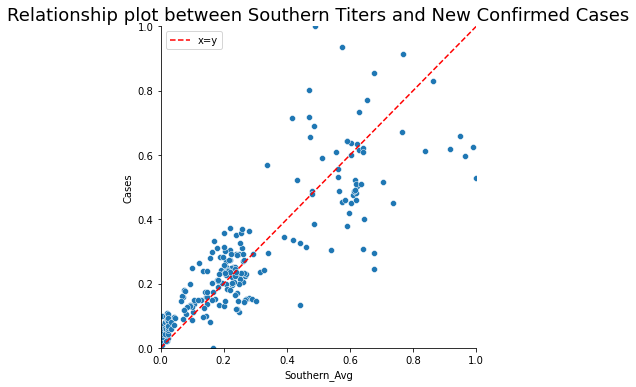

In [28]:
# Scale the values
df_scaled = df_aligned.copy()
scaler = MinMaxScaler()
df_scaled[['Southern_Raw', 'Northern_Raw','Southern_Avg', 'Northern_Avg','Cases', 'Deaths']] = scaler.fit_transform(df_aligned[['Southern_Raw', 'Northern_Raw', 
                                                                                                                    'Southern_Avg', 'Northern_Avg',
                                                                                                                           'Cases_per_100K', 'Deaths_per_100K']])
# Show the relation between norther and souther samples
sns.relplot(data=df_scaled, x="Southern_Avg", y="Cases")
plt.plot([0,1], [0,1], '--r', label="x=y")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.title('Relationship plot between Southern Titers and New Confirmed Cases', fontsize=18, y=1.05)

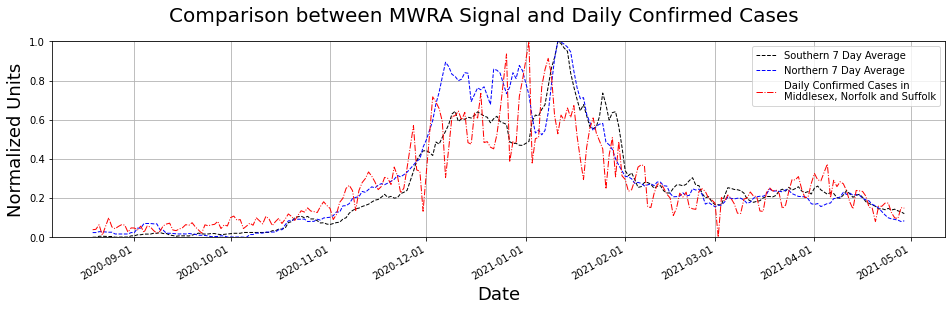

In [29]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_aligned['Date'], normalize(df_aligned['Southern_Avg'].to_numpy()), '--k', linewidth = 1,  label="Southern 7 Day Average")
ax.plot(df_aligned['Date'], normalize(df_aligned['Northern_Avg'].to_numpy()), '--b', linewidth = 1, label="Northern 7 Day Average")
ax.plot(df_aligned['Date'], normalize(df_aligned['Cases'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

In [30]:
# Compute 7 day moving average for cases and deaths
df_aligned['Cases_Avg'] = df_aligned['Cases'].rolling(window=7).mean()
df_aligned['Deaths_Avg'] = df_aligned['Deaths'].rolling(window=7).mean()

# Interpolate head
df_aligned.interpolate(limit_direction="both", inplace=True)

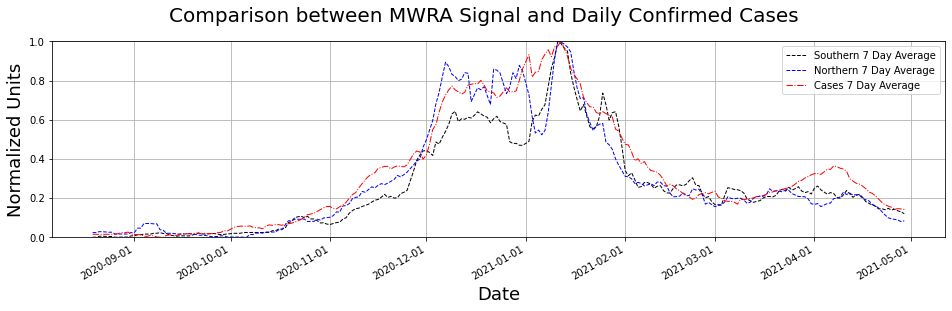

In [31]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_aligned['Date'], normalize(df_aligned['Southern_Avg'].to_numpy()), '--k', linewidth = 1,  label="Southern 7 Day Average")
ax.plot(df_aligned['Date'], normalize(df_aligned['Northern_Avg'].to_numpy()), '--b', linewidth = 1, label="Northern 7 Day Average")
ax.plot(df_aligned['Date'], normalize(df_aligned['Cases_Avg'].to_numpy()), '-.r', linewidth = 1, label="Cases 7 Day Average")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

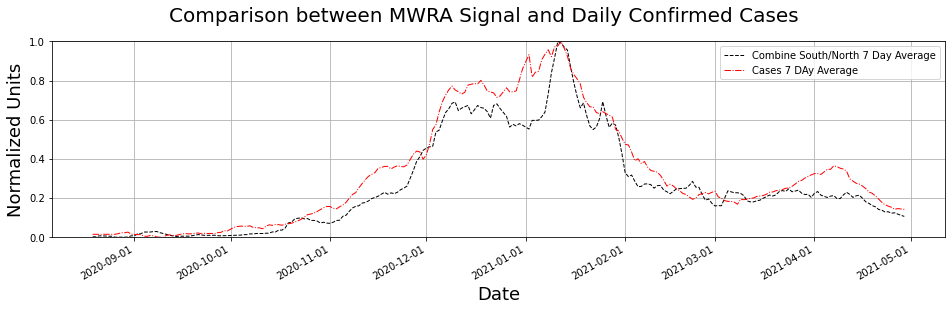

In [32]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
sn_combine = df_aligned['Southern_Avg'] + df_aligned['Northern_Avg'] / 2
ax.plot(df_aligned['Date'], normalize(sn_combine.to_numpy()), '--k', linewidth = 1,  label="Combine South/North 7 Day Average")
ax.plot(df_aligned['Date'], normalize(df_aligned['Cases_Avg'].to_numpy()), '-.r', linewidth = 1, label="Cases 7 DAy Average")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

# Modeling


In [33]:
# Split Dataset into train and test
TRAIN_PERCENTAGE = 0.7;
train_size = int(len(df_aligned) * TRAIN_PERCENTAGE)

df_train, df_test = np.split(df_aligned, [int(TRAIN_PERCENTAGE*len(df_aligned))])
print('Train Size: {}'.format(len(df_train)))
print('Test Size: {}'.format(len(df_test)))

Train Size: 174
Test Size: 75


# Persistence Model

In [34]:
# Create lagged dataset
def persistence_values(x):
    x = pd.DataFrame(x)
    df = pd.concat([x.shift(1), x], axis=1)
    df.columns = ['x', 'y']
    return df

train = persistence_values(df_train['Cases'])
test = persistence_values(df_test['Cases'])

train_X, train_y = train.iloc[:,0], train.iloc[:,1]
test_X, test_y = test.iloc[:,0], test.iloc[:,1]

# persistence model
def model_persistence(x):
    return x

# walk-forward validation
#predictions = [ model_persistence(x) for x in test_X]
test_score = mean_squared_error(test_y[1:], test_X[1:])
print('Test MSE: %.3f' % test_score)

Test MSE: 37707.865


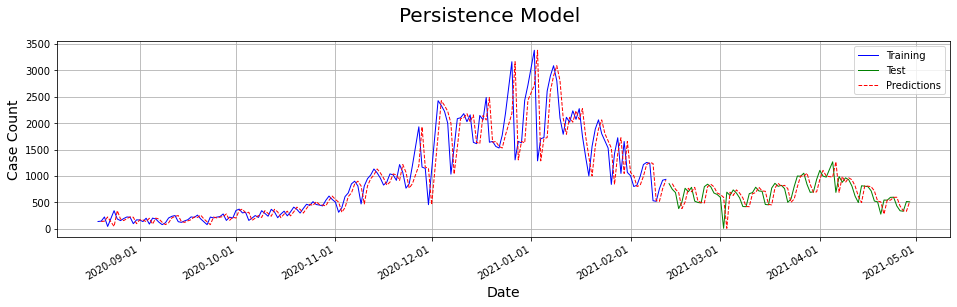

In [35]:
# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'], train_y, 'b', linewidth = 1,  label="Training")
ax.plot(df_train['Date'], train_X, '--r', linewidth = 1)
ax.plot(df_test['Date'], test_y, 'g', linewidth = 1,  label="Test")
ax.plot(df_test['Date'], test_X, '--r', linewidth = 1,  label="Predictions")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)


fig.autofmt_xdate()
fig.suptitle('Persistence Model', fontsize=20, y=1.00)
fig.show()

In [36]:
# Linear Regression Model
X = df_train[['Southern_Raw', 'Northern_Raw']].astype('float')
y = df_train['Cases'].astype('float')

X = sm.add_constant(X) # adding a constant
model_lm1 = sm.OLS(y, X).fit()

# Print summary
model_lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     245.6
Date:                Thu, 06 May 2021   Prob (F-statistic):           5.30e-51
Time:                        16:40:06   Log-Likelihood:                -1293.5
No. Observations:                 174   AIC:                             2593.
Df Residuals:                     171   BIC:                             2603.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          244.3242     45.516      5.368      0.000     154.479     334.170
Southern_Raw     0.3476      0.096      3.623      0.000       0.158       0.537
Northern_Raw     1.3942      0.124     11.210      0.000       1.149       1.640
==============================================================================
Omnibus:                       81.646   Durbin-Watson:                   1.541
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              605.207
Skew:                           1.545   Prob(JB):                    3.81e-132
Kurtosis:                      11.598   Cond. No.                     1.26e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Multiple Linear Regression

In [37]:
train_preds = model_lm1.get_prediction(X).summary_frame()

X_test = df_test[['Southern_Raw', 'Northern_Raw']].astype('float')
X_test = sm.add_constant(X_test) # adding a constant
test_preds = model_lm1.get_prediction(X_test).summary_frame()

In [38]:
execute_all_validations('liner',np.asarray(test_y[1:].values),test_preds['mean'][1:].values)
#extFunc(df_test['Cases_Avg'].values,test_preds['mean'].values)
!cat validation_results.csv

174.31886195952865
51668.88303175306
persistence,2021:05:05,mae_calc,136.75675675675674
persistence,2021:05:05,rmse_calc,37707.86486486487
liner,2021:05:05,mae_calc,174.31886195952865
liner,2021:05:05,rmse_calc,51668.88303175306
gru,2021:05:05,mae_calc,255.51932482449513
gru,2021:05:05,rmse_calc,137840.02764265763
gru,2021:05:05,mae_calc,255.51932482449513
gru,2021:05:05,rmse_calc,137840.02764265763
lstm,2021:05:05,mae_calc,280.1158190073457
lstm,2021:05:05,rmse_calc,159901.4095418361
bi_gru,2021:05:05,mae_calc,259.07324161169663
bi_gru,2021:05:05,rmse_calc,136968.34949688218
bi_lstm,2021:05:05,mae_calc,264.30594946903256
bi_lstm,2021:05:05,rmse_calc,144081.20158393495
xgboost,2021:05:06,mae_calc,219.7781465657552
xgboost,2021:05:06,rmse_calc,79424.75320820413
xgboost,2021:05:06,mae_calc,219.7781465657552
xgboost,2021:05:06,rmse_calc,79424.75320820413
xgboost-fewer-param,2021:05:06,mae_calc,233.61712422688802
xgboost-fewer-param,2021:05:06,rmse_calc,90718.27601793167
xgboost,2021:05:06

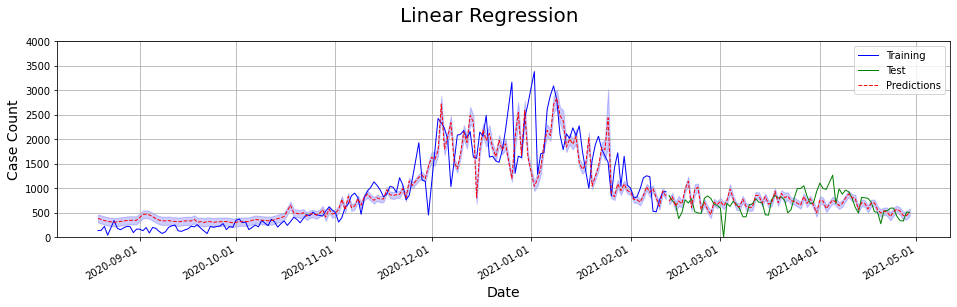

In [39]:
 
 
 # plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'], train_y, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'], test_y, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'], train_preds['mean'], '--r', linewidth = 1)
ax.plot(df_test['Date'], test_preds['mean'], '--r', linewidth = 1,  label="Predictions")

# CI for the predection at each x value, i.e. the line itself
ax.fill_between(df_train['Date'], train_preds['mean_ci_lower'], 
                train_preds['mean_ci_upper'], color='b', alpha=.2)

ax.fill_between(df_test['Date'], test_preds['mean_ci_lower'], 
                test_preds['mean_ci_upper'], color='b', alpha=.2)
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylim([0,4000])


fig.autofmt_xdate()
fig.suptitle('Linear Regression', fontsize=20, y=1.00)
fig.show()

# Polynomal Regression

In [40]:
def generate_poly_features(x, degree):
    poly = PolynomialFeatures(degree=degree)
    xp = poly.fit_transform(x)
    return xp

def generate_polynomial_model(x, y, degree):
    xp = generate_poly_features(x, degree)
    return xp, sm.OLS(y, xp).fit()

NameError: ignored

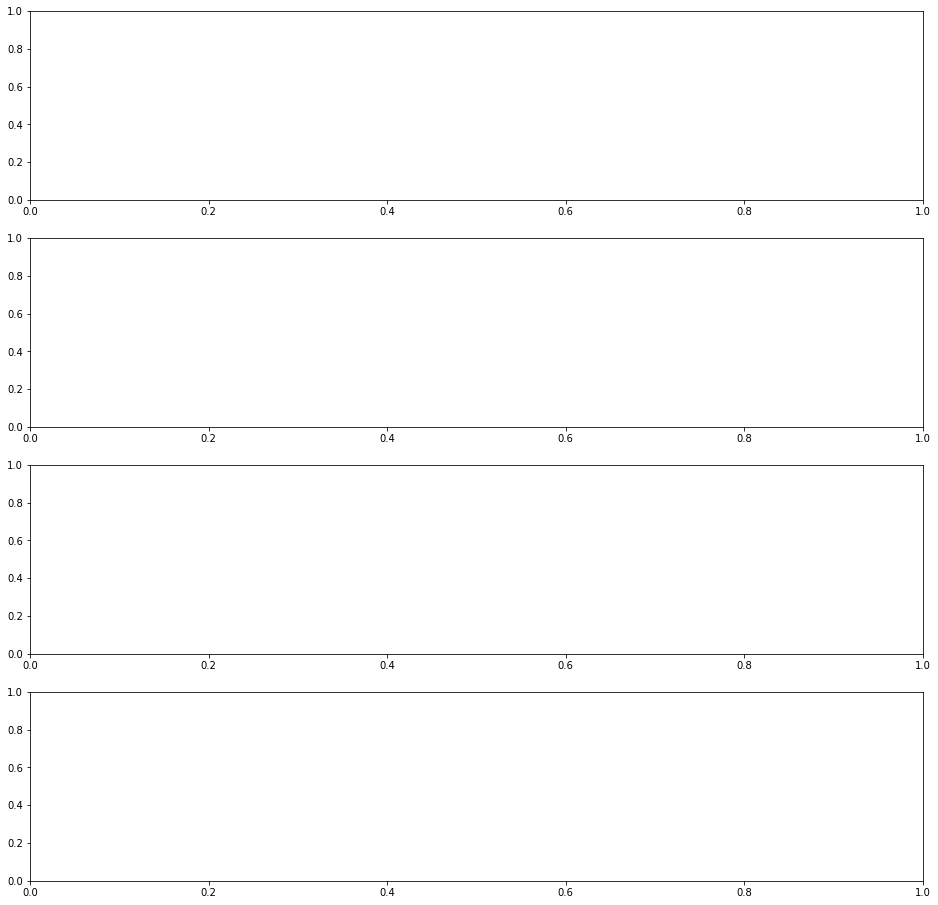

In [41]:
#your code here
poly_models = list()
degrees = [2,3,5,8]

# plot predictions and expected results
fig, ax = plt.subplots(nrows = 4, ncols = 1, sharey=True, figsize=(16,16))
ax = ax.flatten()

X = df_train[['Southern_Raw', 'Northern_Raw']].astype('float')
y = df_train['Cases'].astype('float')
    
for i, (model, degree) in enumerate(zip(models, degrees)):

    # Generate model
    X_train , model = generate_polynomial_model(X, y, degree)
    
    # Add model to list
    poly_models.append(model)
    
    # Generate x_test
    X_test = generate_poly_features(df_test[['Southern_Raw', 'Northern_Raw']].astype('float'), degree)
    
    # Generate predictions
    train_preds = model.get_prediction(X_train).summary_frame()
    test_preds = model.get_prediction(X_test).summary_frame()
    
    ax[i].plot(df_train['Date'], train_y, 'b', linewidth = 1,  label="Training")
    ax[i].plot(df_test['Date'], test_y, 'g', linewidth = 1,  label="Test")
    ax[i].plot(df_train['Date'], train_preds['mean'], '--r', linewidth = 1)
    ax[i].plot(df_test['Date'], test_preds['mean'], '--r', linewidth = 1,  label="Predictions")

    # CI for the predection at each x value, i.e. the line itself
    ax[i].fill_between(df_train['Date'], train_preds['mean_ci_lower'], 
                    train_preds['mean_ci_upper'], color='b', alpha=.2)

    ax[i].fill_between(df_test['Date'], test_preds['mean_ci_lower'], 
                    test_preds['mean_ci_upper'], color='b', alpha=.2)

    ax[i].grid(True)
    ax[i].legend()
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[i].set_title(f'Degree: {degree}', fontsize=14)
    ax[i].set_ylabel(f'Case Count', fontsize = 14)
    ax[i].set_xlabel('Date', fontsize = 14)
    ax[i].set_ylim([0,4000])

    
fig.autofmt_xdate()
fig.suptitle('Polynomial Regression', fontsize=20, y=0.95)
fig.show()

# Generalized Linear Model with Poisson Regression

$\theta = exp(\beta_0 + \beta_1 X_1 + \beta_2 X_2)$

$Y_{count} \sim Poisson(\theta)$

In [42]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_train[['Southern_Raw', 'Northern_Raw', 'Cases']].astype('float'))

In [43]:
print(scaled)

[[8.26005862e-03 4.61538462e-02 2.81352888e-02]
 [6.41309491e-03 3.72637193e-02 3.02304699e-02]
 [4.26325606e-03 2.72727273e-02 5.38760850e-02]
 [2.53803767e-03 1.99959568e-02 0.00000000e+00]
 [5.32907008e-04 1.18881119e-02 8.94941634e-02]
 [1.73728189e-03 1.49639658e-02 4.25022448e-02]
 [3.19744205e-03 1.88811189e-02 3.32235858e-02]
 [4.15992343e-03 2.30453798e-02 4.48967375e-02]
 [5.06261657e-03 2.72727273e-02 5.38760850e-02]
 [5.87381946e-03 2.85026423e-02 5.23795271e-02]
 [6.66281789e-03 2.71534061e-02 1.58635139e-02]
 [7.46069811e-03 2.79720280e-02 3.74139479e-02]
 [8.38900308e-03 5.55743352e-02 3.68153248e-02]
 [9.32587264e-03 8.60139860e-02 2.75366657e-02]
 [9.05941913e-03 8.95521132e-02 4.66926070e-02]
 [8.79296563e-03 8.18181818e-02 1.34690213e-02]
 [9.81342024e-03 6.39600192e-02 4.72912302e-02]
 [1.10504212e-02 4.27482729e-02 4.22029333e-02]
 [1.22568612e-02 2.65734266e-02 2.36456151e-02]
 [1.31997331e-02 1.89742369e-02 1.04759054e-02]
 [1.38555822e-02 1.74825175e-02 2.065249

In [44]:
x1 = scaled[:,0]
x2 = scaled[:,1]
y_obs = scaled[:,2]

In [45]:
with pm.Model() as model_glm_poisson:

    # Define Prior Distributions (Betas)
    b0 = pm.Normal("b0_intercept", mu=0, sigma=10)
    b1 = pm.Normal("b1_Southern", mu=0, sigma=10)
    b2 = pm.Normal("b2_Northern", mu=0, sigma=10)
    
    # Deterministic variable
    # define linear model and exp link function
    #theta = (b0 + b1*x1 + b2*x2)
    theta = pm.Deterministic('theta',pm.math.exp(b0 + b1*x1 + b2*x2))

    # Likelihood function Y ~ Poisson(theta)
    ## Define Poisson likelihood
    Y_obs = pm.Poisson("Y_obs", mu=theta, observed=y_obs)

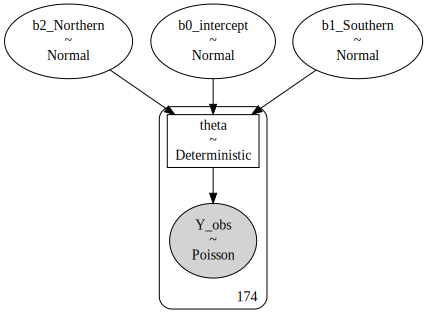

In [46]:
pm.model_to_graphviz(model_glm_poisson)

In [47]:
np.seterr(divide='ignore') # Suppress divide by zero warning
with model_glm_poisson:
    print(f'Starting MCMC process')
    nsamples = 20000 # number of samples to keep
    burnin = 4000 # burnin period
    trace = pm.sample(nsamples, tune=burnin, target_accept=0.9, cores=4, random_seed = 109)#, return_inferencedata=False) # return_inferencedata = False to suppress warning 
    print(f'DONE')

Starting MCMC process


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b2_Northern, b1_Southern, b0_intercept]


Sampling 4 chains for 4_000 tune and 20_000 draw iterations (16_000 + 80_000 draws total) took 192 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


DONE


In [51]:
!pip install pymc3>=3.8

In [49]:
!pip install arviz

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


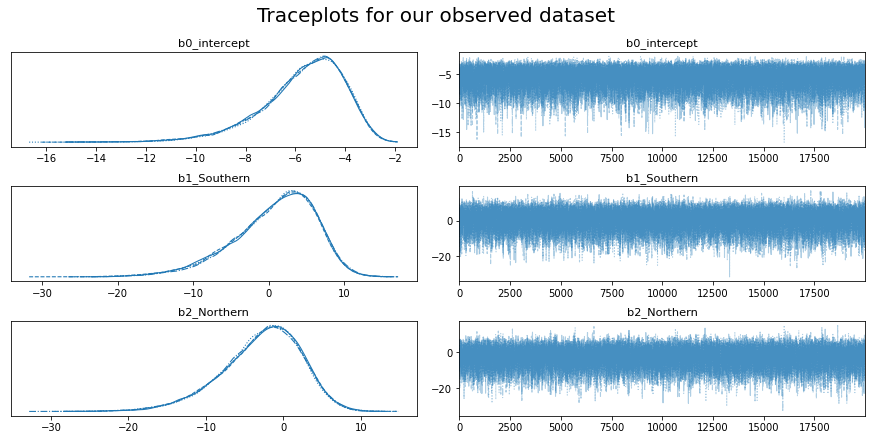

In [52]:
# Plot only mu0, tau0 and beta1,2,3
varnames = ['b0_intercept', 'b1_Southern', 'b2_Northern']
title = f'Traceplots for our observed dataset'
az.plot_trace(trace, var_names = varnames, compact=True, divergences = None);
plt.suptitle( title, fontsize=20 )
plt.show()

In [53]:
print(f'R-hat values for hidden parameters')
results = az.summary(
    trace, 
    var_names = varnames
)
display(results)

R-hat values for hidden parameters


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0_intercept,-5.713,1.692,-8.929,-2.984,0.012,0.009,22912.0,20257.0,1.0
b1_Southern,0.768,5.473,-10.158,9.710,0.040,0.029,19605.0,22329.0,1.0
b2_Northern,-2.877,5.157,-12.759,6.268,0.037,0.027,20113.0,22912.0,1.0


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9d4c0dba90>],
      dtype=object)

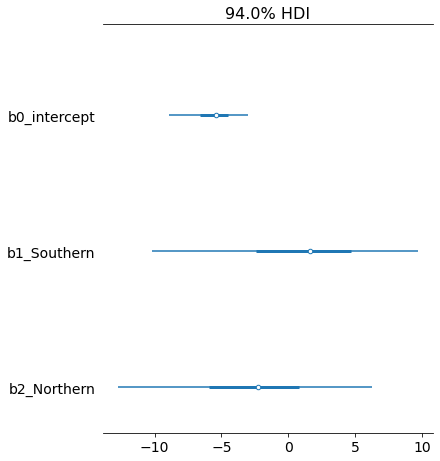

In [54]:
az.plot_forest(trace, var_names = varnames, combined=True)

In [59]:
def model_glm_predict(trace, x):
    beta0 = trace['b0_intercept']
    beta1 = trace['b1_Southern']
    beta2 = trace['b2_Northern']
    
    # Create the prediction model
    x1 = x[0]
    x2 = x[1]
    
    # Theta
    m_theta = np.outer(beta0, np.ones(shape=(len(x1),))) +\
                np.outer(beta1, x1) +\
                np.outer(beta2, x2)
    
    m_mus = np.exp(m_theta)
    m_y = np.mean(m_mus, axis=0)
    
    # Pick most frequent value
    return m_y

mus = model_glm_predict(trace, [x1,x2])

# PyGAM

In [61]:
X_train, y_train = df_train[['Southern_Raw', 'Northern_Raw']].astype('float'), df_train['Cases'].astype('float')
X_test, y_test = df_test[['Southern_Raw', 'Northern_Raw']].astype('float'), df_test['Cases'].astype('float')

formula = s(0) + s(1)

model_gam = LinearGAM(formula).fit(X_train, y_train)

In [62]:
# Create our model, we'll use grid search to find best smoothing parameter for each feature using a randomized 
# search grid as suggested by pyGAM docs
# https://readthedocs.org/projects/pygam/downloads/pdf/latest/
n_features = 2 # Southern_raw and Northern_raw
lams = 10 ** (np.random.rand(100, n_features) * 6 - 3)

gam = LinearGAM(s(0) + s(1))
gam.gridsearch(X_train.to_numpy(), y_train.to_numpy(), lam=lams)

100% (100 of 100) |######################| Elapsed Time: 0:00:04 Time:  0:00:04


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + intercept, 
   tol=0.0001, verbose=False)

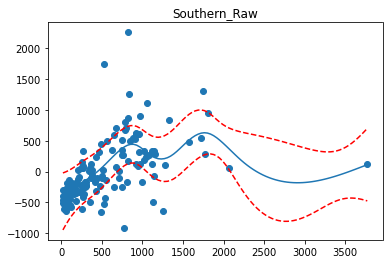

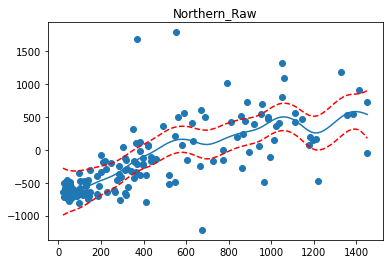

In [63]:
#your code here
res = model_gam.deviance_residuals(X_train,y_train)
for i, term in enumerate(model_gam.terms):
    if term.isintercept:
        continue

    XX = model_gam.generate_X_grid(term=i)
    pdep, confi = model_gam.partial_dependence(term=i, X=XX, width=0.95)
    pdep2, _ = model_gam.partial_dependence(term=i, X=X_train, width=0.95)
    plt.figure()
    plt.scatter(X_train.iloc[:,term.feature], pdep2 + res)
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(X_train.columns.values[term.feature])
    plt.show()

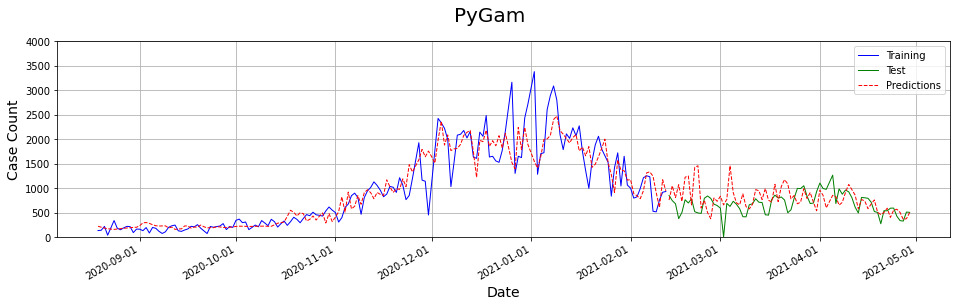

In [64]:
# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'], y_train, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'], y_test, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'], model_gam.predict(X_train), '--r', linewidth = 1)
ax.plot(df_test['Date'], model_gam.predict(X_test), '--r', linewidth = 1,  label="Predictions")

# CI for the predection at each x value, i.e. the line itself
#ax.fill_between(df_train['Date'], train_preds['mean_ci_lower'], 
#                train_preds['mean_ci_upper'], color='b', alpha=.2)

#ax.fill_between(df_test['Date'], test_preds['mean_ci_lower'], 
#                test_preds['mean_ci_upper'], color='b', alpha=.2)
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Case Count', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylim([0,4000])


fig.autofmt_xdate()
fig.suptitle('PyGam', fontsize=20, y=1.00)
fig.show()

array([ 759.75119266, 1050.87895319,  808.99287009, 1072.51507919,
        730.93275585, 1226.29266759, 1249.74857069,  659.24080324,
       1428.90430137, 1458.7373033 ,  594.36826677,  752.59675952,
        503.49008625,  375.73726058,  801.66709362,  732.71655887,
        836.92923291,  659.29619323,  772.90646166, 1461.47584108,
        910.58906879,  702.17413061,  661.11054708,  886.11043188,
        622.98182557,  578.61888697,  670.94487874,  971.7798062 ,
        948.22413824,  768.76129036,  994.9405121 ,  756.00403647,
        717.72635493, 1080.42365583,  726.853409  , 1038.97697455,
       1176.27944424, 1087.65405984,  783.61914105,  850.76898287,
        682.98249685,  715.17926947,  989.15298051,  789.72523783,
        913.03296256,  714.20377462,  539.73635239,  962.14800154,
        855.36816121,  599.80303051,  855.18219127,  828.13146138,
        655.23910155,  711.39504625,  914.80777344, 1079.07288757,
        969.38758944,  859.25222111,  578.48928659,  769.82987

In [71]:
#execute_all_validations('pygam',np.asarray(y_test[1:].values),test_preds['mean'][1:].values)
execute_all_validations('pygam',np.asarray(y_test[1:].values),model_gam.predict(X_test)[:74])

#extFunc(df_test['Cases_Avg'].values,test_preds['mean'].values)
!cat validation_results.csv

256.130199082044
112713.65900243842
persistence,2021:05:05,mae_calc,136.75675675675674
persistence,2021:05:05,rmse_calc,37707.86486486487
liner,2021:05:05,mae_calc,174.31886195952865
liner,2021:05:05,rmse_calc,51668.88303175306
gru,2021:05:05,mae_calc,255.51932482449513
gru,2021:05:05,rmse_calc,137840.02764265763
gru,2021:05:05,mae_calc,255.51932482449513
gru,2021:05:05,rmse_calc,137840.02764265763
lstm,2021:05:05,mae_calc,280.1158190073457
lstm,2021:05:05,rmse_calc,159901.4095418361
bi_gru,2021:05:05,mae_calc,259.07324161169663
bi_gru,2021:05:05,rmse_calc,136968.34949688218
bi_lstm,2021:05:05,mae_calc,264.30594946903256
bi_lstm,2021:05:05,rmse_calc,144081.20158393495
xgboost,2021:05:06,mae_calc,219.7781465657552
xgboost,2021:05:06,rmse_calc,79424.75320820413
xgboost,2021:05:06,mae_calc,219.7781465657552
xgboost,2021:05:06,rmse_calc,79424.75320820413
xgboost-fewer-param,2021:05:06,mae_calc,233.61712422688802
xgboost-fewer-param,2021:05:06,rmse_calc,90718.27601793167
xgboost,2021:05:06,

In [74]:
val_df = pd.read_csv('validation_results.csv',names=['model_name','date','metrix','value'])
val_df.drop_duplicates()
val_df.sort_values(by = ['metrix','value'])

,model_name,date,metrix,value
0,persistence,2021:05:05,mae_calc,136.756757
2,liner,2021:05:05,mae_calc,174.318862
24,liner,2021:05:06,mae_calc,174.318862
26,liner,2021:05:06,mae_calc,174.318862
28,liner,2021:05:06,mae_calc,174.318862
14,xgboost,2021:05:06,mae_calc,219.778147
16,xgboost,2021:05:06,mae_calc,219.778147
20,xgboost,2021:05:06,mae_calc,219.778147
18,xgboost-fewer-param,2021:05:06,mae_calc,233.617124
22,xgboost-fewer-param,2021:05:06,mae_calc,233.617124
